# Implicit & LightFM

В данном jupyter notebook рассматриваются как использовать implicit и LightFM для построения рекомендаций

* [Load data](#load-data)
* [Validation](#validation)
* [Implicit](#implicit)
* [LightFM](#lightfm)
* [Links](#links)

In [ ]:
import os
import numpy as np 
import pandas as pd 
import scipy.sparse as sp
from itertools import islice, cycle
from more_itertools import pairwise
from tqdm.auto import tqdm


os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

print('Dataset:')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

<a id="load-data"></a>
# Load data

Возьмем уже предобработанный данные из [metrics-validation-strategies-and-baselines](https://www.kaggle.com/sharthz23/metrics-validation-strategies-and-baselines/output)

In [ ]:
df = pd.read_pickle('../input/metrics-validation-strategies-and-baselines/interactions_preprocessed.pickle')
df_users = pd.read_pickle('../input/metrics-validation-strategies-and-baselines/users_preprocessed.pickle')
df_items = pd.read_pickle('../input/metrics-validation-strategies-and-baselines/items_preprocessed.pickle')

df.shape, df_users.shape, df_items.shape

In [ ]:
df.head()

In [ ]:
users_inv_mapping = dict(enumerate(df['user_id'].unique()))
users_mapping = {v: k for k, v in users_inv_mapping.items()}
len(users_mapping)

In [ ]:
items_inv_mapping = dict(enumerate(df['item_id'].unique()))
items_mapping = {v: k for k, v in items_inv_mapping.items()}
len(items_mapping)

In [ ]:
df_items['title'] = df_items['title'].str.lower()

In [ ]:
item_titles = pd.Series(df_items['title'].values, index=df_items['id']).to_dict()
len(item_titles), item_titles[128115]

In [ ]:
title_items = df_items.groupby('title')['id'].agg(list)
title_items

In [ ]:
title_count = title_items.map(len)
title_count.value_counts()

In [ ]:
title_items[title_count > 1].tail()

In [ ]:
df_items[df_items['title'] == 'ящик пандоры']

In [ ]:
title_items[title_count > 1].head()

In [ ]:
df_items[df_items['title'] == '451 градус по фаренгейту']

In [ ]:
df['rating'] = np.array(df['rating'].values, dtype=np.float32)

df.loc[df['item_id'].isin([44681, 162716])].groupby('item_id').agg({
    'progress': np.size,
    'rating': ['mean'],
    'start_date': ['min', 'max'],
})

<a id="validation"></a>
# Validation

Для наших данных выбрем 7 последних дней и будем тестировать на них последовательно (1 test fold - 1 день).

Но теперь нам нужно учитывать проблему холодного старта. Это основная проблем классических метод над матрицей взаимодействий.
Поэтому напишем свой класс для разбиения исходного датафрейма на train/test

In [ ]:
class TimeRangeSplit():
    """
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html
    """
    def __init__(self, 
                 start_date, 
                 end_date=None, 
                 freq='D', 
                 periods=None, 
                 tz=None, 
                 normalize=False, 
                 closed=None, 
                 train_min_date=None,
                 filter_cold_users=True, 
                 filter_cold_items=True, 
                 filter_already_seen=True):
        
        self.start_date = start_date
        if end_date is None and periods is None:
            raise ValueError("Either 'end_date' or 'periods' must be non-zero, not both at the same time.")

        self.end_date = end_date
        self.freq = freq
        self.periods = periods
        self.tz = tz
        self.normalize = normalize
        self.closed = closed
        self.train_min_date = pd.to_datetime(train_min_date, errors='raise')
        self.filter_cold_users = filter_cold_users
        self.filter_cold_items = filter_cold_items
        self.filter_already_seen = filter_already_seen

        self.date_range = pd.date_range(
            start=start_date, 
            end=end_date, 
            freq=freq, 
            periods=periods, 
            tz=tz, 
            normalize=normalize, 
            closed=closed)

        self.max_n_splits = max(0, len(self.date_range) - 1)
        if self.max_n_splits == 0:
            raise ValueError("Provided parametrs set an empty date range.") 

    def split(self, 
              df, 
              user_column='user_id',
              item_column='item_id',
              datetime_column='date',
              fold_stats=False):
        df_datetime = df[datetime_column]
        if self.train_min_date is not None:
            train_min_mask = df_datetime >= self.train_min_date
        else:
            train_min_mask = df_datetime.notnull()

        date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
                                     (self.date_range <= df_datetime.max())]

        for start, end in pairwise(date_range):
            fold_info = {
                'Start date': start,
                'End date': end
            }
            train_mask = train_min_mask & (df_datetime < start)
            train_idx = df.index[train_mask]
            if fold_stats:
                fold_info['Train'] = len(train_idx)

            test_mask = (df_datetime >= start) & (df_datetime < end)
            test_idx = df.index[test_mask]
            
            if self.filter_cold_users:
                new = np.setdiff1d(
                    df.loc[test_idx, user_column].unique(), 
                    df.loc[train_idx, user_column].unique())
                new_idx = df.index[test_mask & df[user_column].isin(new)]
                test_idx = np.setdiff1d(test_idx, new_idx)
                test_mask = df.index.isin(test_idx)
                if fold_stats:
                    fold_info['New users'] = len(new)
                    fold_info['New users interactions'] = len(new_idx)

            if self.filter_cold_items:
                new = np.setdiff1d(
                    df.loc[test_idx, item_column].unique(), 
                    df.loc[train_idx, item_column].unique())
                new_idx = df.index[test_mask & df[item_column].isin(new)]
                test_idx = np.setdiff1d(test_idx, new_idx)
                test_mask = df.index.isin(test_idx)
                if fold_stats:
                    fold_info['New items'] = len(new)
                    fold_info['New items interactions'] = len(new_idx)

            if self.filter_already_seen:
                user_item = [user_column, item_column]
                train_pairs = df.loc[train_idx, user_item].set_index(user_item).index
                test_pairs = df.loc[test_idx, user_item].set_index(user_item).index
                intersection = train_pairs.intersection(test_pairs)
                test_idx = test_idx[~test_pairs.isin(intersection)]
                # test_mask = rd.df.index.isin(test_idx)
                if fold_stats:
                    fold_info['Known interactions'] = len(intersection)

            if fold_stats:
                fold_info['Test'] = len(test_idx)

            yield (train_idx, test_idx, fold_info)

    def get_n_splits(self, df, datetime_column='date'):
        df_datetime = df[datetime_column]
        if self.train_min_date is not None:
            df_datetime = df_datetime[df_datetime >= self.train_min_date]

        date_range = self.date_range[(self.date_range >= df_datetime.min()) & 
                                     (self.date_range <= df_datetime.max())]

        return max(0, len(date_range) - 1)

In [ ]:
last_date = df['start_date'].max().normalize()
folds = 7
start_date = last_date - pd.Timedelta(days=folds)
start_date, last_date

In [ ]:
cv = TimeRangeSplit(start_date=start_date, periods=folds+1)

cv.max_n_splits, cv.get_n_splits(df, datetime_column='start_date')

In [ ]:
cv.date_range

In [ ]:
folds_with_stats = list(cv.split(
    df, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='start_date',
    fold_stats=True
))

folds_info_with_stats = pd.DataFrame([info for _, _, info in folds_with_stats])

In [ ]:
folds_info_with_stats

In [ ]:
fold_dates = [(info['Start date'], info['End date']) for _, _, info in folds_with_stats]
fold_dates

In [ ]:
def compute_metrics(df_true, df_pred, top_N):
    result = {}
    test_recs = df_true.set_index(['user_id', 'item_id']).join(df_pred.set_index(['user_id', 'item_id']))
    test_recs = test_recs.sort_values(by=['user_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='user_id')['rank'].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs['rank']).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='user_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs['rank']
    
    users_count = test_recs.index.get_level_values('user_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs['rank'] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    result[f'MRR'] = test_recs.groupby(level='user_id')['reciprocal_rank'].max().mean()
    return pd.Series(result)

<a id="implicit"></a>
# Implicit

Библиотека для построения рекомендательных систем на основе датасетов с неявным таргетом.
* Репо - https://github.com/benfred/implicit
* Документация - https://implicit.readthedocs.io/en/latest/

Входные данные - разреженные матрицы (либо csr_matrix, либо coo_matrix) с типом float32/float64

In [ ]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.loc[train_idx]
test = df.loc[test_idx]
train.shape, test.shape

In [ ]:
info['Train'], info['Test']

In [ ]:
def get_coo_matrix(df, 
                   user_col='user_id', 
                   item_col='item_id', 
                   weight_col=None, 
                   users_mapping=users_mapping, 
                   items_mapping=items_mapping):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)

    interaction_matrix = sp.coo_matrix((
        weights, 
        (
            df[user_col].map(users_mapping.get), 
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [ ]:
train_mat = get_coo_matrix(train).tocsr()
train_mat

## Item-to-item модели

**Векорное представление для объекта** - весь столбец из матрицы взаимодействий (user_item) матрица

**Процесс построения рекомендаций** - поиск похожих объектов (по косинусной близости) для всех объектов, с которыми пользователь уже взаимодействовал и выдача топа из этого списка

**Пространство для тюнинга** - взвешние на уровне таблицы, взвешивание элементов матрицы (на уровне моделей), кол-во соседей `K`

In [ ]:
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender

Этим модели для Item-to-item подхода ожидают на вход матрицу в ориентации item_user, поэтому в `fit` передаем `train_mat.T`

In [ ]:
cosine_model = CosineRecommender(K=10)
cosine_model.fit(train_mat.T) # 

In [ ]:
top_N = 10
user_id = test['user_id'].iloc[0]
row_id = users_mapping[user_id]
print(f'Рекомендации для пользователя {user_id}, номер строки - {row_id}')

Параметр `K` влияет на максимальную выдачу топа, поэтому `N` для таких моделей желательно указывать меньше `K`

In [ ]:
recs = cosine_model.recommend(row_id, train_mat, N=top_N, filter_already_liked_items=True)
recs = pd.DataFrame(recs, columns=['col_id', 'similarity'])
recs

In [ ]:
recs['item_id'] = recs['col_id'].map(items_inv_mapping.get)
recs['title'] = recs['item_id'].map(item_titles.get)
recs

In [ ]:
def generate_implicit_recs_mapper(model, train_matrix, N, user_mapping, item_inv_mapping):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.recommend(user_id, 
                               train_matrix, 
                               N=N, 
                               filter_already_liked_items=True)
        return [item_inv_mapping[item] for item, _ in recs]
    return _recs_mapper

In [ ]:
mapper = generate_implicit_recs_mapper(cosine_model, train_mat, top_N, users_mapping, items_inv_mapping)
mapper

In [ ]:
%time
recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})
recs['item_id'] = recs['user_id'].map(mapper)
recs.head()

In [ ]:
recs = recs.explode('item_id')
recs['rank'] = recs.groupby('user_id').cumcount() + 1
recs.head(top_N + 2)

In [ ]:
metrics = compute_metrics(test, recs, top_N)
metrics

Как видно, на матрице, заполненной единицами, CosineRecommender с K=10 уже дает метрики немного лучше, чем просто учет популярного

In [ ]:
%%time
validation_results = pd.DataFrame()

for train_idx, test_idx, info in folds_with_stats:
    print(f"test range - from {info['Start date']} to {info['End date']}")
    train = df.loc[train_idx]
    test = df.loc[test_idx]
    print(f'train shape - {train.shape}, test shape - {test.shape}')
    
    train_mat = get_coo_matrix(train).tocsr()
    
    cosine_model = CosineRecommender(K=10)
    cosine_model.fit(train_mat.T) # 
    
    mapper = generate_implicit_recs_mapper(cosine_model, train_mat, top_N, users_mapping, items_inv_mapping)
    
    recs = pd.DataFrame({
        'user_id': test['user_id'].unique()
    })
    recs['item_id'] = recs['user_id'].map(mapper)
    recs = recs.explode('item_id')
    recs['rank'] = recs.groupby('user_id').cumcount() + 1
    fold_result = compute_metrics(test, recs, top_N)
    fold_result.at['Date'] = info['Start date']
    fold_result.at['argv'] = 'K=10'
    fold_result.at['Model'] = 'cosine model'
    
    validation_results = validation_results.append(fold_result, ignore_index=True)

In [ ]:
validation_results

In [ ]:
validation_results.agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

In [ ]:
for model_class in [BM25Recommender, TFIDFRecommender]:
    for train_idx, test_idx, info in folds_with_stats:
        print(f"test range - from {info['Start date']} to {info['End date']}")
        train = df.loc[train_idx]
        test = df.loc[test_idx]
        print(f'train shape - {train.shape}, test shape - {test.shape}')
        
        train_mat = get_coo_matrix(train).tocsr()
        
        model = model_class(K=10)
        model.fit(train_mat.T, show_progress=False) 

        mapper = generate_implicit_recs_mapper(model, train_mat, top_N, users_mapping, items_inv_mapping)

        recs = pd.DataFrame({
            'user_id': test['user_id'].unique()
        })
        recs['item_id'] = recs['user_id'].map(mapper)
        recs = recs.explode('item_id')
        recs['rank'] = recs.groupby('user_id').cumcount() + 1
        fold_result = compute_metrics(test, recs, top_N)
        fold_result.at['Date'] = info['Start date']
        fold_result.at['argv'] = 'K=10'
        fold_result.at['Model'] = model.__class__.__name__

        validation_results = validation_results.append(fold_result, ignore_index=True)

In [ ]:
validation_results

In [ ]:
validation_results.groupby(['Model', 'argv']).agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

In [ ]:
model

In [ ]:
model.similarity

In [ ]:
model.similar_items(7789, N=10)

In [ ]:
def get_similar_books(title, model, N=10, idx=0, 
                      title_items=title_items, item_titles=item_titles, items_mapping=items_mapping, items_inv_mapping=items_inv_mapping):
    item_ids = title_items.at[title]
    if len(item_ids) == 1:
        item_id = item_ids[0]
    else:
        item_id = item_ids[idx]
    
    col_id = items_mapping[item_id]
    similar = model.similar_items(col_id, N=N)
    similar = pd.DataFrame(similar, columns=['col_id', 'similarity'])
    similar['item_id'] = similar['col_id'].map(items_inv_mapping.get)
    similar['title'] = similar['item_id'].map(item_titles.get)
    return similar

In [ ]:
get_similar_books('мастер и маргарита', model)

In [ ]:
get_similar_books('пикник на обочине', model)

## AlternatingLeastSquares

**Векорное представление** - на основе разложения матрицы взамиодействий (с весами) в произведение двух матриц. 
Одна матрица размерности `[users x factors]` содержит векторные представления всех пользователей,
другая матрица `[items x factors]` для объектов

**Процесс построения рекомендаций** - для конкретного пользователя ищутся такие объекты, что скалярное произведение их векторов максимально.

**Пространство для тюнинга** 
* взвешивание на уровне таблицы
* `factors` - размерность итоговых векторов (обычно степени 2-ки, от 16 до 256)
* `iterations` - кол-во итераций (от 10 до 100)
* `regularization` - регуляризация векторов (степени 10-ки, от 0.0001 до 1)

Есть возможность использовать GPU через `use_gpu=True` и ApproximateNearestNeighbors (на уровне модели)

In [ ]:
from implicit.als import AlternatingLeastSquares

In [ ]:
for train_idx, test_idx, info in folds_with_stats:
    print(f"test range - from {info['Start date']} to {info['End date']}")
    train = df.loc[train_idx]
    test = df.loc[test_idx]
    print(f'train shape - {train.shape}, test shape - {test.shape}')
    
    train_mat = get_coo_matrix(train).tocsr()
    
    als_model = AlternatingLeastSquares(factors=32, iterations=30, num_threads=4)
    als_model.fit(train_mat.T) 
    
    mapper = generate_implicit_recs_mapper(als_model, train_mat, top_N, users_mapping, items_inv_mapping)
    
    recs = pd.DataFrame({
        'user_id': test['user_id'].unique()
    })
    recs['item_id'] = recs['user_id'].map(mapper)
    recs = recs.explode('item_id')
    recs['rank'] = recs.groupby('user_id').cumcount() + 1
    metrics = compute_metrics(test, recs, top_N)
    
    fold_result = pd.Series(metrics)
    fold_result.at['Date'] = info['Start date']
    fold_result.at['argv'] = 'factors=32 iterations=30'
    fold_result.at['Model'] = als_model.__class__.__name__
    
    validation_results = validation_results.append(fold_result, ignore_index=True)

In [ ]:
validation_results.groupby(['Model', 'argv']).agg({
    'MRR': ['mean', 'std', 'min', 'max'],
    'MAP@10': ['mean', 'std', 'min', 'max'],
    'Recall@10': ['mean', 'std', 'min', 'max'],
})

In [ ]:
als_model.user_factors.shape, als_model.item_factors.shape

In [ ]:
get_similar_books('мастер и маргарита', als_model)

In [ ]:
get_similar_books('пикник на обочине', als_model)

In [ ]:
similar_users = als_model.similar_users(0, N=5)
similar_users

In [ ]:
similar_users = als_model.similar_users(144, N=5)
for (uid, sim) in similar_users:
    user_id = users_inv_mapping[uid]
    print(f'User ID - {user_id} ({sim:.4f})')
    user_mask = train['user_id'] == user_id
    user_items = train.loc[user_mask, 'item_id'].map(item_titles.get)
    print(user_items.to_string(index=False))

<a id="lightfm"></a>
# LightFM

Библиотека для построения рекомендательных систем с помощью матричных разложений и фичей
* Репо - https://github.com/lyst/lightfm
* Документация - https://making.lyst.com/lightfm/docs/home.html

Входные данные - разреженные матрицы (либо csr_matrix, либо coo_matrix)
Модель одна, варируются только loss functions. Также есть вспомогательный класс lightfm.data.Dataset для построения как матрицы взаимодействий, так и матриц фичей

**Основая идея** - построить векторные представления для каждой фичи по пользователю и объекту. Если фичей нет, то просто используем индикаторные фичи (единичная матрица по пользователям и объектам соответственно)
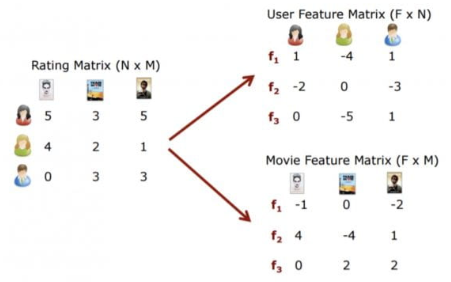
[image source](https://sites.northwestern.edu/msia/2019/04/24/personalized-restaurant-recommender-system-using-hybrid-approach/#:~:text=LightFM%20incorporates%20matrix%20factorization%20model,retain%20the%20original%20interaction%20matrix.&text=The%20latent%20embeddings%20could%20capture,items%2C%20which%20represent%20their%20tastes.)

**Векорное представление** - векторы для пользователя и объекта получают суммирование векторов их фичей.

**Процесс построения рекомендаций** - для конкретного пользователя ищутся такие объекты, что скалярное произведение их векторов максимально.

**Пространство для тюнинга** 
* взвешивание на уровне таблицы
* `loss` - обучение функции ранжирования.
    * `logistic`
    * `bpr`
    * `warp`
    * `warp-kos`
* `no_components` - размерность итоговых векторов (обычно степени 2-ки, от 16 до 256)
* `learning_rate` - "скорость" обучения
* `item_alpha`/`user_alpha` - регуляризация (степени 10-ки, от 0.0001 до 1)

In [ ]:
from lightfm.data import Dataset
from lightfm import LightFM

In [ ]:
dataset = Dataset()

In [ ]:
dataset.fit(df['user_id'].unique(), df['item_id'].unique())

In [ ]:
df_users['age'] = df_users['age'].cat.add_categories('age_unknown')
df_users['age'] = df_users['age'].fillna('age_unknown')
age_features = df_users['age'].unique()
age_features

In [ ]:
df_users['sex'] = np.array(df_users['sex'].astype(str))
df_users['sex'] = df_users['sex'].fillna('age_unknown')
sex_features = df_users['sex'].unique()
sex_features

In [ ]:
users_features = np.append(age_features, sex_features)
users_features

In [ ]:
dataset.fit_partial(user_features=users_features)

In [ ]:
df_items['genres'] = df_items['genres'].cat.add_categories('genre_unknown')
df_items['genres'] = df_items['genres'].fillna('genre_unknown')
genres = list(df_items['genres'].str.split(',').explode().unique())
len(genres)

In [ ]:
dataset.fit_partial(item_features=genres)

In [ ]:
num_users, num_items = dataset.interactions_shape()
num_users, num_items

In [ ]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('users_mapping len - ', len(lightfm_mapping['users_mapping']))
print('user_features_mapping len - ', len(lightfm_mapping['user_features_mapping']))
print('items_mapping len - ', len(lightfm_mapping['items_mapping']))
print('Users item_features_mapping len - ', len(lightfm_mapping['item_features_mapping']))

In [ ]:
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [ ]:
num_user_features = dataset.user_features_shape()
num_show_features = dataset.item_features_shape()
print('Num user features: {} -> {}\nnum item features: {} -> {}.'.format(
    num_user_features[1] - num_users, num_user_features[1], 
    num_show_features[1] - num_items, num_show_features[1]))

Как собрать теперь наши матрицы. 
* Для интеракций нужен итератор на 
    * `[(user_id1, item_id1), (user_id2, item_id2), ...]`  
    * `[(user_id1, item_id1, weight), (user_id2, item_id2, weight), ...]`
* Для фичей нужен итератор на 
    * `[(id, [feature1, feature2, ...]), (id, [feature1, feature2, ...]), ...]`  
    * `[(id, {feature1: weight}), (id, {feature1: weight}), ...]`

In [ ]:
def df_to_tuple_iterator(df):
    return zip(*df.values.T)

def concat_last_to_list(t):
    return (t[0], list(t[1:])[0])

def df_to_tuple_list_iterator(df):
    return map(concat_last_to_list, zip(*df.values.T))

In [ ]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.loc[train_idx]
test = df.loc[test_idx]

In [ ]:
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(train[['user_id', 'item_id']]))
train_mat

In [ ]:
train_mat_weights

In [ ]:
df_users['features'] = df_users[['age', 'sex']].astype(str).apply(lambda x: list(x), axis=1)
df_users.head()

In [ ]:
known_users_filter = df_users['user_id'].isin(df['user_id'].unique())
train_user_features = dataset.build_user_features(
    df_to_tuple_list_iterator(
        df_users.loc[known_users_filter, ['user_id', 'features']]
    )
)
train_user_features

In [ ]:
df_items['features'] = df_items['genres'].str.split(',')
df_items.head()

In [ ]:
df_items['features'].map(len).value_counts(dropna=False)

In [ ]:
known_items_filter = df_items['id'].isin(df['item_id'].unique())
train_items_features = dataset.build_item_features(
    df_to_tuple_list_iterator(
        df_items.loc[known_items_filter, ['id', 'features']]
    )
)
train_items_features

In [ ]:
lfm_model = LightFM(no_components=64, learning_rate=0.05, loss='warp', max_sampled=5, random_state=23)

In [ ]:
num_epochs = 15
for _ in tqdm(range(num_epochs), total=num_epochs):
    lfm_model.fit_partial(
        train_mat, 
        user_features=train_user_features,
        item_features=train_items_features,
        num_threads=4
    )

In [ ]:
top_N = 10
user_id = test['user_id'].iloc[0]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Рекомендации для пользователя {user_id}, номер строки - {row_id}')

In [ ]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

In [ ]:
pred = lfm_model.predict(row_id, all_cols, user_features=train_user_features, item_features=train_items_features, num_threads=4)
pred, pred.shape

In [ ]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

In [ ]:
pred[top_cols]

In [ ]:
np.max(pred)

In [ ]:
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_titles.get)
recs

In [ ]:
recs = pd.DataFrame({
    'user_id': test['user_id'].unique()
})

In [ ]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [ ]:
known_items = train.groupby('user_id')['item_id'].apply(list).to_dict()
len(known_items)

In [ ]:
known_items[100]

In [ ]:
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=train_user_features, 
    item_features=train_items_features, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=4
)

In [ ]:
%%time
recs['item_id'] = recs['user_id'].map(mapper)

In [ ]:
recs.head()

In [ ]:
recs = recs.explode('item_id')
recs['rank'] = recs.groupby('user_id').cumcount() + 1

In [ ]:
metrics = compute_metrics(test, recs, top_N)
metrics

<a id="links"></a>
# Links
* https://www.benfrederickson.com/distance-metrics/ - шикарная статья про разные метрики в kNN для рекомендательных систем (Item2Item, User2User)
* https://habr.com/ru/post/486802/ - хорошая статья про разные методы (теория)
* https://github.com/dmitryhd/lightfm - форк lightfm от ребят с Авито
* https://habr.com/ru/company/avito/blog/439206/ - обзор применения указанного выше форка на recsys challenge 2018